In [1]:
# Preparando requerimientos
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
#Uso del backend de TensorFlow.
RANDOM_SEED = 42
TRAIN_CASE = 'casosConfirmados'
TRAIN_LOCATION = 'Bolivar'
DATATRAIN_SOURCE_FILE = 'c:\\Users\\juank\\Modelo predictivo COVID-19\\Covid-19EC_Dataset.csv'
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 2000
DAYS_TO_PREDICT = 30

In [3]:
np.random.seed(RANDOM_SEED)

## Obtención del conjunto de datos

In [4]:
df = pd.read_csv(DATATRAIN_SOURCE_FILE)
if TRAIN_LOCATION:
    df = df.loc[df['provincia']==TRAIN_LOCATION]
df.drop(['provincia'], axis=1, inplace=True)
df.set_index('fecha', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df

,día,mes,año,casosConfirmados,casosDiarios,fallecimientos,nuevosFallecimientos,región
fecha,,,,,,,,
2020-03-13,13,3,2020,0,0,0,0,Sierra
2020-03-14,14,3,2020,0,0,0,0,Sierra
2020-03-15,15,3,2020,0,0,0,0,Sierra
2020-03-16,16,3,2020,0,0,0,0,Sierra
2020-03-17,17,3,2020,0,0,0,0,Sierra
...,...,...,...,...,...,...,...,...
2021-03-09,9,3,2021,4119,16,83,0,Sierra
2021-03-10,10,3,2021,4160,41,83,0,Sierra
2021-03-11,11,3,2021,4206,46,83,0,Sierra


## Obtención de la caja del tren y eliminación de todos los valores cero

In [6]:
cases = df.filter([TRAIN_CASE])
cases = cases[(cases.T != 0).any()]

### Visualizacion de la tendencia de los casos

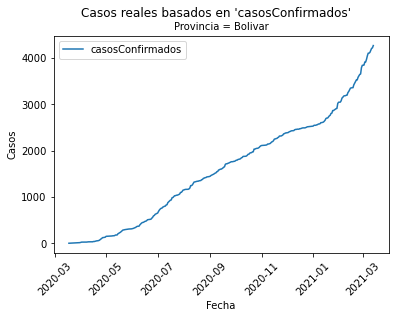

In [7]:
plt.suptitle('Casos reales basados en \'' + TRAIN_CASE + '\'')
plt.title('Provincia = ' + TRAIN_LOCATION, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [8]:
cases.shape

(352, 1)

## Preparación de funciones

In [9]:
# Esto dividirá los datos en un valor X e Y
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

## Preparación de datos y modelos

### Creación de datos de entrenamiento y prueba

In [10]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [11]:
train_cases.shape

(247, 1)

In [12]:
test_cases.shape

(105, 1)

### Normalizacion de los datos

In [13]:
# Escalamiento Minimos y Maximos
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [14]:
all_cases.shape

(352, 1)

In [15]:
train_cases.shape

(247, 1)

In [16]:
test_cases.shape

(105, 1)

### Dividir datos para obtener el valor X e Y

In [17]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [18]:
X_all.shape

(350, 1)

In [19]:
X_train.shape

(245, 1)

In [20]:
X_test.shape

(103, 1)

Es necesario convertir la forma de los datos al formato de forma LSTM (muestras, pasos de tiempo, características)

Para hacer que un modelo pueda aprender de una secuencia, usaremos pasos de tiempo para la predicción de series de tiempo

In [21]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

In [22]:
X_all.shape

(350, 1, 1)

In [23]:
Y_all.shape

(350, 1)

In [24]:
X_train.shape

(245, 1, 1)

In [25]:
Y_train.shape

(245, 1)

In [26]:
X_test.shape

(103, 1, 1)

In [27]:
Y_test.shape

(103, 1)

### Este es el modelo de predicción de series temporales LSTM

In [28]:
batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(4, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(LSTM(1, stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 4)                 96        
                                                                 
 lstm_1 (LSTM)               (1, 1)                    24        
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


### Probando el modelo antes de ir a la predicción futura

Ajuste del modelo con los datos de entrenamiento

In [29]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

Iteration 1/2000
245/245 [==============================] - 5s 2ms/step - loss: 0.1528
Iteration 2/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0573
Iteration 3/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0357
Iteration 4/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0231
Iteration 5/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0165
Iteration 6/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0130
Iteration 7/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0109
Iteration 8/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0095
Iteration 9/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0083
Iteration 10/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0073
Iteration 11/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.0065
Iteration 12/2000
245/245 [==============

245/245 [==============================] - 1s 2ms/step - loss: 1.7057e-04
Iteration 93/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.6123e-04
Iteration 94/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.4928e-04
Iteration 95/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.3357e-04
Iteration 96/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1457e-04
Iteration 97/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.7383e-05
Iteration 98/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.1586e-05
Iteration 99/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.5760e-05
Iteration 100/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.0369e-04
Iteration 101/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1533e-04
Iteration 102/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.2713e-04
Ite

245/245 [==============================] - 1s 2ms/step - loss: 1.9417e-04
Iteration 181/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9548e-04
Iteration 182/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9736e-04
Iteration 183/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9959e-04
Iteration 184/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.0223e-04
Iteration 185/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.0575e-04
Iteration 186/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.1079e-04
Iteration 187/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.1783e-04
Iteration 188/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.2691e-04
Iteration 189/2000
245/245 [==============================] - 1s 3ms/step - loss: 2.3743e-04
Iteration 190/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.4873e

245/245 [==============================] - 1s 3ms/step - loss: 8.0651e-05
Iteration 269/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0480e-05
Iteration 270/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0245e-05
Iteration 271/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9882e-05
Iteration 272/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9451e-05
Iteration 273/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9096e-05
Iteration 274/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.8895e-05
Iteration 275/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.8771e-05
Iteration 276/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.8586e-05
Iteration 277/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.8274e-05
Iteration 278/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.7900e

245/245 [==============================] - 1s 2ms/step - loss: 2.2091e-04
Iteration 357/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9706e-04
Iteration 358/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.3157e-04
Iteration 359/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9039e-04
Iteration 360/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.3876e-04
Iteration 361/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9538e-04
Iteration 362/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.1324e-04
Iteration 363/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.8768e-04
Iteration 364/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.7571e-04
Iteration 365/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.6731e-04
Iteration 366/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.6857e

245/245 [==============================] - 1s 2ms/step - loss: 1.9551e-04
Iteration 445/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.9310e-04
Iteration 446/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.8946e-04
Iteration 447/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.8402e-04
Iteration 448/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.7639e-04
Iteration 449/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.6710e-04
Iteration 450/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.5815e-04
Iteration 451/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.5242e-04
Iteration 452/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.5121e-04
Iteration 453/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.5213e-04
Iteration 454/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.5067e

245/245 [==============================] - 1s 2ms/step - loss: 6.8456e-04
Iteration 534/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.4690e-04
Iteration 535/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.8162e-04
Iteration 536/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0013
Iteration 537/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0014
Iteration 538/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.3625e-04
Iteration 539/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.5970e-04
Iteration 540/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.4187e-04
Iteration 541/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.8507e-04
Iteration 542/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.4387e-04
Iteration 543/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.8936e-04
Iter

245/245 [==============================] - 1s 2ms/step - loss: 3.1913e-04
Iteration 622/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.5465e-04
Iteration 623/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.7132e-04
Iteration 624/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.7833e-04
Iteration 625/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.6736e-04
Iteration 626/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.1705e-04
Iteration 627/2000
245/245 [==============================] - 1s 2ms/step - loss: 6.3176e-04
Iteration 628/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.8465e-04
Iteration 629/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0012
Iteration 630/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0010
Iteration 631/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.6841e-04
Iter

245/245 [==============================] - 1s 2ms/step - loss: 5.9205e-05
Iteration 710/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.0103e-05
Iteration 711/2000
245/245 [==============================] - 1s 2ms/step - loss: 6.5073e-05
Iteration 712/2000
245/245 [==============================] - 1s 2ms/step - loss: 6.6745e-05
Iteration 713/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.8809e-05
Iteration 714/2000
245/245 [==============================] - 1s 2ms/step - loss: 6.3830e-05
Iteration 715/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.8530e-05
Iteration 716/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.8116e-05
Iteration 717/2000
245/245 [==============================] - 1s 2ms/step - loss: 6.0043e-05
Iteration 718/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.5745e-05
Iteration 719/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.6286e

245/245 [==============================] - 1s 2ms/step - loss: 3.3409e-04
Iteration 798/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.4698e-04
Iteration 799/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.3905e-04
Iteration 800/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.0274e-04
Iteration 801/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.6983e-04
Iteration 802/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.4378e-04
Iteration 803/2000
245/245 [==============================] - 1s 3ms/step - loss: 2.3988e-04
Iteration 804/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.5217e-04
Iteration 805/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.6942e-04
Iteration 806/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.7994e-04
Iteration 807/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.8765e

245/245 [==============================] - 1s 2ms/step - loss: 2.4174e-04
Iteration 886/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.9732e-04
Iteration 887/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.5505e-04
Iteration 888/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.0064e-04
Iteration 889/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.2295e-04
Iteration 890/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.2326e-04
Iteration 891/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.1238e-04
Iteration 892/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.0365e-04
Iteration 893/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.0462e-04
Iteration 894/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.1400e-04
Iteration 895/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.2333e

245/245 [==============================] - 1s 2ms/step - loss: 1.3093e-04
Iteration 974/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.4185e-04
Iteration 975/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.6255e-04
Iteration 976/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.0377e-04
Iteration 977/2000
245/245 [==============================] - 1s 2ms/step - loss: 2.7360e-04
Iteration 978/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.8171e-04
Iteration 979/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.5776e-04
Iteration 980/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.7406e-04
Iteration 981/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0015
Iteration 982/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0024
Iteration 983/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0038
Iteratio

245/245 [==============================] - 1s 2ms/step - loss: 5.8420e-04
Iteration 1062/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.8046e-04
Iteration 1063/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0016
Iteration 1064/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0014
Iteration 1065/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0015
Iteration 1066/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0013
Iteration 1067/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0017
Iteration 1068/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0019
Iteration 1069/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0016
Iteration 1070/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0015
Iteration 1071/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0012
Iteration 1072/2000
24

Iteration 1149/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.6045e-05
Iteration 1150/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.7472e-05
Iteration 1151/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.0085e-04
Iteration 1152/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.0596e-04
Iteration 1153/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1047e-04
Iteration 1154/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.0716e-04
Iteration 1155/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.5064e-05
Iteration 1156/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.2764e-05
Iteration 1157/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1957e-04
Iteration 1158/2000
245/245 [==============================] - 1s 3ms/step - loss: 1.8309e-04
Iteration 1159/2000
245/245 [==============================]

245/245 [==============================] - 1s 2ms/step - loss: 3.0581e-04
Iteration 1237/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.0494e-04
Iteration 1238/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.0478e-04
Iteration 1239/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.0527e-04
Iteration 1240/2000
245/245 [==============================] - 1s 3ms/step - loss: 3.0634e-04
Iteration 1241/2000
245/245 [==============================] - 1s 3ms/step - loss: 3.0796e-04
Iteration 1242/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.1009e-04
Iteration 1243/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.1265e-04
Iteration 1244/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.1557e-04
Iteration 1245/2000
245/245 [==============================] - 1s 2ms/step - loss: 3.1875e-04
Iteration 1246/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 3ms/step - loss: 1.0825e-04
Iteration 1324/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.0954e-04
Iteration 1325/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1090e-04
Iteration 1326/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1233e-04
Iteration 1327/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1383e-04
Iteration 1328/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1540e-04
Iteration 1329/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1703e-04
Iteration 1330/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.1873e-04
Iteration 1331/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.2049e-04
Iteration 1332/2000
245/245 [==============================] - 1s 2ms/step - loss: 1.2231e-04
Iteration 1333/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 2ms/step - loss: 8.1052e-05
Iteration 1411/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.2011e-05
Iteration 1412/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.2925e-05
Iteration 1413/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.3785e-05
Iteration 1414/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.4584e-05
Iteration 1415/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.5319e-05
Iteration 1416/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.5984e-05
Iteration 1417/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.6575e-05
Iteration 1418/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.7087e-05
Iteration 1419/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.7519e-05
Iteration 1420/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 2ms/step - loss: 8.0718e-05
Iteration 1498/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0590e-05
Iteration 1499/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0441e-05
Iteration 1500/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0272e-05
Iteration 1501/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.0085e-05
Iteration 1502/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9881e-05
Iteration 1503/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9661e-05
Iteration 1504/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9427e-05
Iteration 1505/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.9183e-05
Iteration 1506/2000
245/245 [==============================] - 1s 2ms/step - loss: 7.8927e-05
Iteration 1507/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 2ms/step - loss: 5.7596e-05
Iteration 1585/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3789e-05
Iteration 1586/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.1336e-05
Iteration 1587/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9873e-05
Iteration 1588/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9129e-05
Iteration 1589/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.8917e-05
Iteration 1590/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9105e-05
Iteration 1591/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9588e-05
Iteration 1592/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.0294e-05
Iteration 1593/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.1191e-05
Iteration 1594/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 2ms/step - loss: 5.0825e-05
Iteration 1672/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.0463e-05
Iteration 1673/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.0151e-05
Iteration 1674/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9881e-05
Iteration 1675/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9651e-05
Iteration 1676/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9456e-05
Iteration 1677/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9290e-05
Iteration 1678/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9151e-05
Iteration 1679/2000
245/245 [==============================] - 1s 2ms/step - loss: 4.9036e-05
Iteration 1680/2000
245/245 [==============================] - 1s 3ms/step - loss: 4.8942e-05
Iteration 1681/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 1s 2ms/step - loss: 8.0619e-04
Iteration 1759/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.1566e-04
Iteration 1760/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0010
Iteration 1761/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0011
Iteration 1762/2000
245/245 [==============================] - 1s 3ms/step - loss: 0.0011
Iteration 1763/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0012
Iteration 1764/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0011
Iteration 1765/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0011
Iteration 1766/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.0010
Iteration 1767/2000
245/245 [==============================] - 1s 2ms/step - loss: 9.4756e-04
Iteration 1768/2000
245/245 [==============================] - 1s 2ms/step - loss: 8.6863e-04
Iteration 1769

245/245 [==============================] - 1s 2ms/step - loss: 5.3434e-05
Iteration 1846/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3312e-05
Iteration 1847/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3415e-05
Iteration 1848/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3315e-05
Iteration 1849/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3423e-05
Iteration 1850/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3326e-05
Iteration 1851/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3450e-05
Iteration 1852/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3346e-05
Iteration 1853/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3485e-05
Iteration 1854/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.3370e-05
Iteration 1855/2000
245/245 [==============================] - 1s 2ms/step - los

245/245 [==============================] - 0s 2ms/step - loss: 5.2336e-05
Iteration 1933/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2416e-05
Iteration 1934/2000
245/245 [==============================] - 1s 2ms/step - loss: 5.2229e-05
Iteration 1935/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2311e-05
Iteration 1936/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2121e-05
Iteration 1937/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2206e-05
Iteration 1938/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2013e-05
Iteration 1939/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2103e-05
Iteration 1940/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.1907e-05
Iteration 1941/2000
245/245 [==============================] - 0s 2ms/step - loss: 5.2001e-05
Iteration 1942/2000
245/245 [==============================] - 0s 2ms/step - los